In [ ]:
import tensorflow as tf

In [ ]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
class_names = ['T-shirt/top','Trousers','Pullover','Dress','Coat','Sandals','Shirt','Sneaker','Bag','Ankle boot']

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
target_classes = [5, 7, 9] #Classes: Sandals, Sneakes, Ankle Boot

In [ ]:
train_mask = np.isin(y_train, target_classes)
test_mask = np.isin(y_test, target_classes)
x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]


In [ ]:
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
label_map = {5: 0, 7: 1, 9: 2} #Changing target classes to 0, 1, 2
y = np.vectorize(label_map.get)(y)

Splitting the dataset into training, validation and test set and scaling in the range [0, 1].

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=2/7, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
x_train, x_val, x_test = x_train / 255, x_val / 255, x_test / 255

In [ ]:
def print_class_distribution(y, subset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"\n{subset_name} set class distribution:")
    for label, count in zip(unique, counts):
        percentage = 100 * count / total
        print(f"  Class {label}: {count} samples ({percentage:.2f}%)")

print_class_distribution(y_train, "Training")
print_class_distribution(y_test, "Testing")
print_class_distribution(y_val, "Validation")


Training set class distribution:
  Class 0: 5000 samples (33.33%)
  Class 1: 5000 samples (33.33%)
  Class 2: 5000 samples (33.33%)

Testing set class distribution:
  Class 0: 1000 samples (33.33%)
  Class 1: 1000 samples (33.33%)
  Class 2: 1000 samples (33.33%)

Validation set class distribution:
  Class 0: 1000 samples (33.33%)
  Class 1: 1000 samples (33.33%)
  Class 2: 1000 samples (33.33%)


All classes are equally distributed in the training, test and validation set.

Building the encoder, decoder and the stacked autoencoder.

In [ ]:
def create_autoencoder1():
  stacked_encoder1 = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu')
  ])

  stacked_decoder1 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
      tf.keras.layers.Reshape((28, 28))
  ])

  stacked_ae1 = tf.keras.Sequential([stacked_encoder1, stacked_decoder1])

  optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
  stacked_ae1.compile(optimizer=optimizer, loss='binary_crossentropy')
  print(stacked_ae1.summary())

  return stacked_ae1

In [ ]:
def create_autoencoder2():
  stacked_encoder2 = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.ActivityRegularization(l1=1e-6)
  ])

  stacked_decoder2 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
      tf.keras.layers.Reshape((28, 28))
  ])

  stacked_ae2 = tf.keras.Sequential([stacked_encoder2, stacked_decoder2])

  optimizer2 = tf.keras.optimizers.Nadam(learning_rate=1e-4)
  stacked_ae2.compile(optimizer=optimizer2, loss='binary_crossentropy')
  print(stacked_ae2.summary())

  return stacked_ae2

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-2, monitor='val_loss', patience=5, restore_best_weights=True)

We call each function two times. One to train each model with batch size equal to 32 and the second with batch size equal to 256. We don't just create a model and train it with two different batch sizes because we need to initialize the weights.

In [ ]:
ae11 = create_autoencoder1()
history11 = ae11.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_val, x_val), callbacks=[early_stopping])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 50)             │       213,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 28, 28)         │       214,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,354 (1.63 MB)

 Trainable params: 428,354 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4636 - val_loss: 0.2820
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2740 - val_loss: 0.2581
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2547 - val_loss: 0.2472
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2438 - val_loss: 0.2401
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2392 - val_loss: 0.2351
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2337 - val_loss: 0.2313
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2306 - val_loss: 0.2283
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2270 - val_loss: 0.2258
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2245 - val_loss: 0.2237
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2218 - val_loss: 0.2221
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2205 - val_loss: 0.2206
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms

The encoder has 784 ⋅ 256 + 256 (bias) = 200960 parameters from the first layer and 256 ⋅  50 + 50 (bias) = 12850 parameters from the second. So the total parameters for the encoder are 200960 + 12850 = 213810.
Similarly, the decoder has (50 ⋅ 256 + 256) + (256 ⋅ 784 + 784) = 13056 + 201488 = 214544 parameters.

In [ ]:
ae21 = create_autoencoder1()
history21 = ae21.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_val, x_val), callbacks=[early_stopping])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 50)             │       213,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 28, 28)         │       214,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,354 (1.63 MB)

 Trainable params: 428,354 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4552 - val_loss: 0.2806
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2732 - val_loss: 0.2586
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2541 - val_loss: 0.2462
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2430 - val_loss: 0.2391
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2378 - val_loss: 0.2344
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2325 - val_loss: 0.2310
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2303 - val_loss: 0.2283
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2266 - val_loss: 0.2259
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2249 - val_loss: 0.2241
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2236 - val_loss: 0.2223
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2206 - val_loss: 0.2208
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms

In [ ]:
ae12 = create_autoencoder1()
history12 = ae12.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_val, x_val), callbacks=[early_stopping])

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 50)             │       213,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 28, 28)         │       214,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,354 (1.63 MB)

 Trainable params: 428,354 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.6652 - val_loss: 0.4736
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4246 - val_loss: 0.3414
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3292 - val_loss: 0.3065
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3006 - val_loss: 0.2922
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2876 - val_loss: 0.2826
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2808 - val_loss: 0.2753
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2724 - val_loss: 0.2699
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2667 - val_loss: 0.2650
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2630 - val_loss: 0.2609
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2586 - val_loss: 0.2572
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2549 - val_loss: 0.2538
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2514 - 

The second model has the same number of parameters as the first one.

In [ ]:
ae22 = create_autoencoder2()
history22 = ae22.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_val, x_val), callbacks=[early_stopping])

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 50)             │       213,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 28, 28)         │       214,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,354 (1.63 MB)

 Trainable params: 428,354 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.6721 - val_loss: 0.4939
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4446 - val_loss: 0.3652
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3552 - val_loss: 0.3336
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3290 - val_loss: 0.3179
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3142 - val_loss: 0.3051
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3015 - val_loss: 0.2947
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2913 - val_loss: 0.2871
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2846 - val_loss: 0.2808
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2777 - val_loss: 0.2755
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2738 - val_loss: 0.2708
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2693 - val_loss: 0.2666
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2651 - 

When we train the models with batch size = 32, training stops after 14 epochs for both models, but when we train them with batch size = 256, training stops after 20 epochs for the first model and after 23 epochs for the second model (due to early stopping in both scenarios).

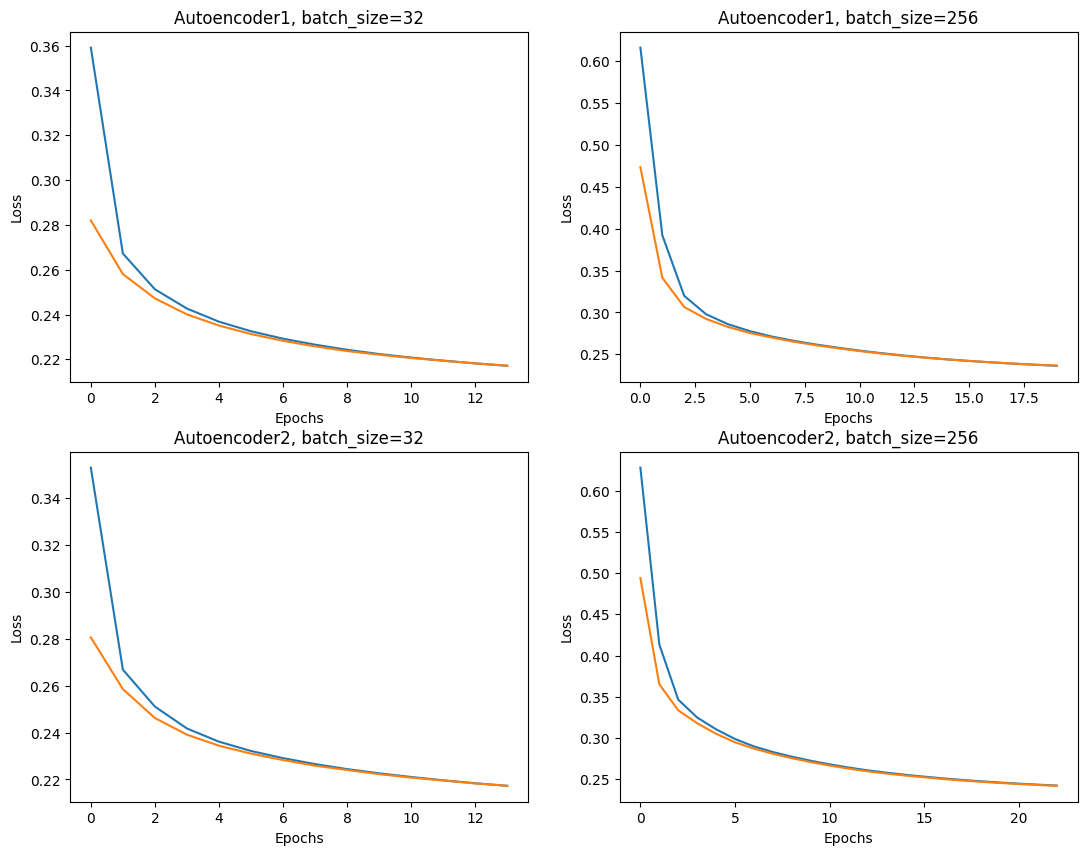

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

plt.subplot(2, 2, 1)
plt.plot(history11.history["loss"])
plt.plot(history11.history["val_loss"])
plt.title("Autoencoder1, batch_size=32")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(2, 2, 2)
plt.plot(history12.history["loss"])
plt.plot(history12.history["val_loss"])
plt.title("Autoencoder1, batch_size=256")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(2, 2, 3)
plt.plot(history21.history["loss"])
plt.plot(history21.history["val_loss"])
plt.title("Autoencoder2, batch_size=32")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(2, 2, 4)
plt.plot(history22.history["loss"])
plt.plot(history22.history["val_loss"])
plt.title("Autoencoder2, batch_size=256")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

Both models seem to train very well for all batch sizes, as both the training and the validation loss drop smoothly and the models don't seem to overfit.

In [ ]:
def compare_images(model, im, num):
  pred_im = model.predict(im[:num])
  pred_im = np.clip(pred_im, 0, 1)
  fig, ax = plt.subplots(2, num, figsize=(15, 5))
  fig.suptitle('Original and reconstructed images', fontsize=15)
  fig.text(0.5, 0.91, 'Original', ha='center', va='center', fontsize=12)
  fig.text(0.5, 0.46, 'Reconstructed', ha='center', va='center', fontsize=12)
  for i in range(num):
    ax[0, i].imshow(im[i])
    ax[0, i].axis('off')
    ax[1, i].imshow(pred_im[i].reshape(28, 28))
    ax[1, i].axis('off')

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


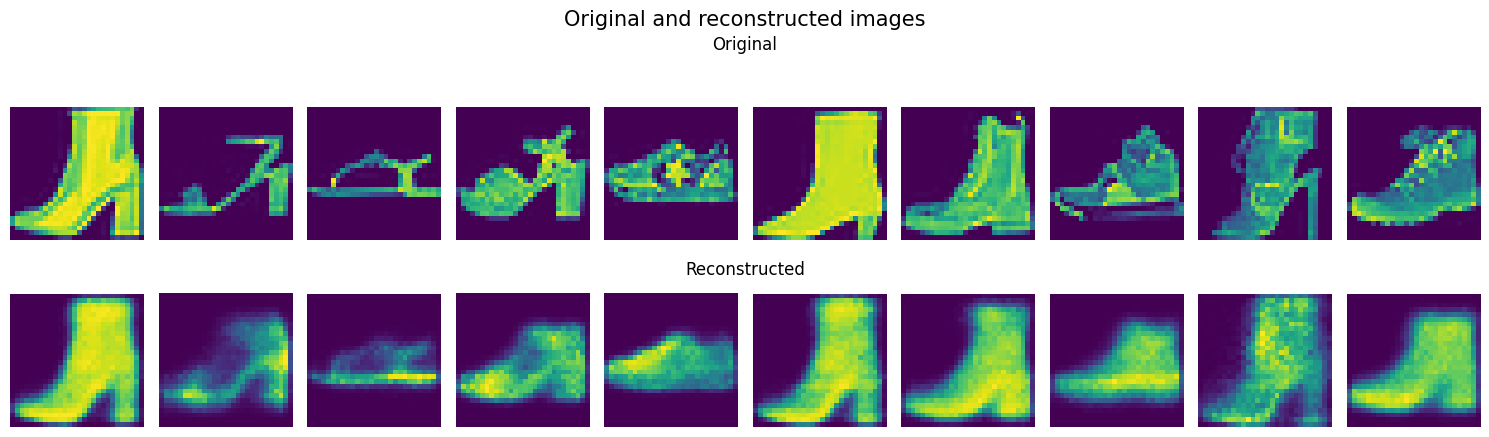

In [ ]:
compare_images(ae12, x_test, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


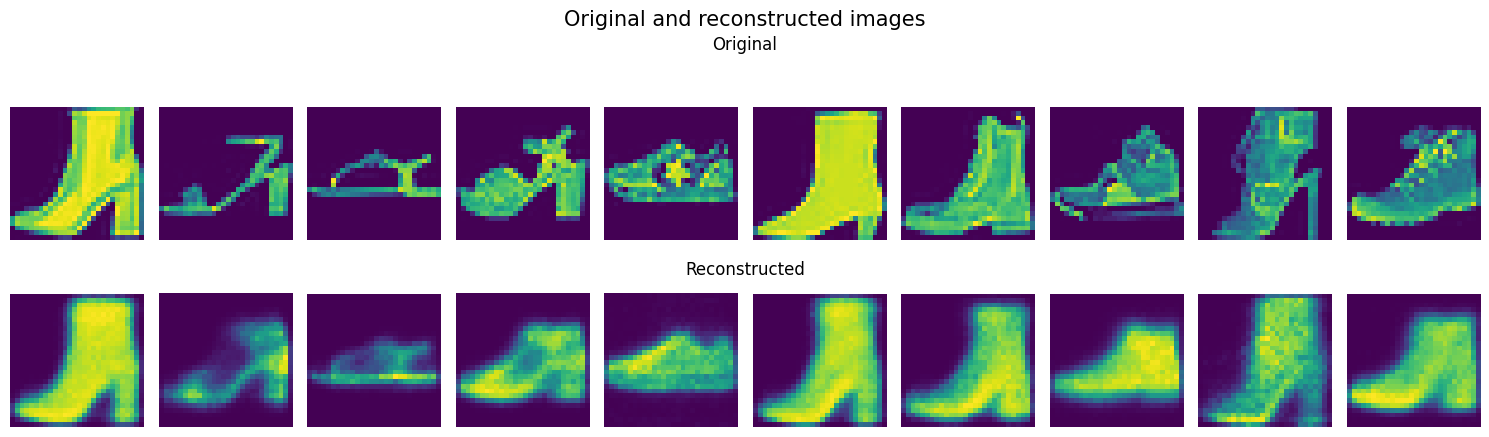

In [ ]:
compare_images(ae22, x_test, 10)

We can see that both models have found the patterns of the images. They are very good at creating images of ankle boots but they find it more difficult to capture some details, like shoelaces in sneakers.